<a href="https://colab.research.google.com/github/Ejeat12/Profolio/blob/main/Homer_Flanders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For this Project, I will attempt to build a model that recognizes whether a quote is from Homer Simpson or his neighbor, Ned Flanders. Based on the input text the model will output a 1 if Homer said it or a 0 if Flanders said it.



In [ ]:
# Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-01-06 02:15:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-06 02:15:07 (86.3 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
# load in test and train excel files into colab
unzip_data("/content/Quotes dataset.zip")

# Downloading our dataset

---



In [ ]:
# Import excel files into pandas
import pandas as pd
data = pd.read_excel("/content/train.xlsx")
test_data = pd.read_excel("/content/Test.xlsx")
train_df = pd.DataFrame(data)
test_df = pd.DataFrame(test_data)
train_df


,ID,KEYWORD,TEXT,TARGET
0,1,dead,I’ve learned that life is one crushing defeat ...,1.0
1,2,gun,"A gun is not a weapon, it’s a tool, like a ham...",1.0
2,3,weasel,Weaseling out of things is important to learn;...,1.0
3,4,dead,"If he’s so smart, how come he’s dead?",1.0
4,5,Marge,"Marge, you know it’s rude to talk when my mout...",1.0
...,...,...,...,...
120,121,Homer,"Homer, I’d love to chitty-chat, but tonight’s ...",0.0
121,122,Call,"Call me Delta Airlines, because I can’t handle...",0.0
122,123,Homer,"Homer, I can’t believe you’re partaking with m...",0.0
123,124,Kindest,"He’s the kindest, sweetest, most generous guy ...",0.0


In [ ]:
# Drop NAN values from datasets
import numpy as np
train_df_shuffled_3 = train_df.fillna(999, inplace=True)
train_df_shuffled_3

In [ ]:
# Shuffle training data
train_df_shuffled_3 = train_df.sample(frac = 1)
len(train_df_shuffled_3)

125

In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 125
Total test samples: 60
Total samples: 185


# Spliting data into training and validation set

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled_3["TEXT"].to_numpy(),
                                                                            train_df_shuffled_3["TARGET"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

# Convert text to numbers.
# Note: This is for demonstration puurposes only, as later I will be building a pretrained model, that comes with it's own text vectorizer layer

In [ ]:
# Find average number of tokens (words) in training set
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

16

In [ ]:
# Setup text vectorization with custom variables
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_length = 1000
max_length = 16

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "Doh!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 16), dtype=int64, numpy=array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
There are some things we don’t want to know. Important things.      

Vectorized version:


<tf.Tensor: shape=(1, 16), dtype=int64, numpy=
array([[ 57,  36,  73,  32,  37,  11,  54,   4,  61, 218,  32,   0,   0,
          0,   0,   0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 577
Top 5 most common words: ['', '[UNK]', 'you', 'i', 'to']
Bottom 5 least common words: ['alright', 'airlines', 'after', 'across', 'able']




```
# This is formatted as code
```

# Create an embedding layer
# Note: Again I will not be using this for our model, since the pretrained one comes with an embedding layer as well.

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
All right, brain. You don’t like me and I don’t like you, but let’s just do this and I can get back to killing you with beer.      

Embedded version:


<tf.Tensor: shape=(1, 16, 128), dtype=float32, numpy=
array([[[-0.01299536, -0.03285937,  0.02369577, ...,  0.01118424,
         -0.04721683,  0.00531303],
        [-0.024382  ,  0.00070715,  0.00269014, ...,  0.01255615,
         -0.03073683, -0.03106214],
        [-0.0041585 ,  0.00584383,  0.00529372, ...,  0.04984415,
         -0.02270833, -0.00952915],
        ...,
        [ 0.04808941, -0.04536462,  0.03222281, ..., -0.03928091,
          0.01089339,  0.03936294],
        [ 0.04978979, -0.0019431 , -0.00039934, ..., -0.01621551,
          0.03926425,  0.02467387],
        [-0.02971206,  0.02606628, -0.01831409, ..., -0.01888737,
          0.04710903,  0.01127892]]], dtype=float32)>

# Creating a baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 38.46%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

# Creating an evaluation function for our model experiments

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 38.46153846153847,
 'precision': 0.7948717948717949,
 'recall': 0.38461538461538464,
 'f1': 0.29230769230769227}

# Build a model with TensorFlow Hub Pretrained Sentence Encoder

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.03126131 -0.01274797 -0.00654278 -0.00387086  0.0249747   0.04729778
  0.03468437 -0.0512713  -0.00527914  0.03141837  0.01844031  0.02338649
 -0.00381352  0.01579623 -0.03729814  0.01848715 -0.03050391  0.07419645
  0.02892086  0.05966044 -0.03032556  0.0115238   0.00197295  0.0265187
 -0.01401997 -0.02775035 -0.02939904  0.02237395  0.02709572 -0.01903179
 -0.01956608  0.00514684 -0.03970383 -0.01524145 -0.01797794 -0.03875121
 -0.0426767   0.0225762   0.04689171  0.01904346  0.01198152 -0.01196674
  0.01235088  0.05598375 -0.07745321 -0.00541877 -0.0684968  -0.04368059
 -0.05208568 -0.01977972], shape=(50,), dtype=float32)


In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Create model 
model = tf.keras.Sequential([
  sentence_encoder_layer, 
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_USE")


model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
model__history = model.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230106-021545
Epoch 1/5
4/4 [==============================] - 3s 181ms/step - loss: 0.7423 - accuracy: 0.5446 - val_loss: 0.6660 - val_accuracy: 0.6923
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: -4.0566 - accuracy: 0.7500 - val_loss: 0.6723 - val_accuracy: 0.6154
Epoch 3/5
4/4 [==============================] - 0s 21ms/step - loss: -6.4136 - accuracy: 0.7143 - val_loss: 0.6780 - val_accuracy: 0.3846
Epoch 4/5
4/4 [==============================] - 0s 22ms/step - loss: -8.5986 - accuracy: 0.6696 - val_loss: 0.6834 - val_accuracy: 0.3846
Epoch 5/5
4/4 [==============================] - 0s 22ms/step - loss: -11.5631 - accuracy: 0.6518 - val_loss: 0.6880 - val_accuracy: 0.3846


In [ ]:
# Make predictions with USE TF Hub model
model_pred_probs = model.predict(val_sentences)
model_pred_probs[:10]

1/1 [==============================] - 0s 417ms/step


array([[0.54189664],
       [0.54097545],
       [0.6389879 ],
       [0.5813119 ],
       [0.56947947],
       [0.5431404 ],
       [0.56268734],
       [0.5087847 ],
       [0.5495334 ],
       [0.5166052 ]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_preds = tf.squeeze(tf.round(model_pred_probs))
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model performance metrics
model_results = calculate_results(val_labels, model_preds)
model_results

{'accuracy': 38.46153846153847,
 'precision': 0.7948717948717949,
 'recall': 0.38461538461538464,
 'f1': 0.29230769230769227}

# Build another model with 10% of data

In [ ]:
# (split the already split train_sentences/train_labels)

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)



In [ ]:
# Clone model but reset weights
model_2 = tf.keras.models.clone_model(model)

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model)
model_2.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 10% of the training data
model_2_history = model_2.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230106-021554
Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.7133 - accuracy: 0.1667 - val_loss: 0.6950 - val_accuracy: 0.4615
Epoch 2/5
1/1 [==============================] - 0s 58ms/step - loss: 0.6940 - accuracy: 0.4167 - val_loss: 0.6981 - val_accuracy: 0.3846
Epoch 3/5
1/1 [==============================] - 0s 57ms/step - loss: 0.6757 - accuracy: 0.8333 - val_loss: 0.7012 - val_accuracy: 0.2308
Epoch 4/5
1/1 [==============================] - 0s 47ms/step - loss: 0.6586 - accuracy: 0.9167 - val_loss: 0.7042 - val_accuracy: 0.3077
Epoch 5/5
1/1 [==============================] - 0s 58ms/step - loss: 0.6428 - accuracy: 1.0000 - val_loss: 0.7073 - val_accuracy: 0.3077


In [ ]:
# Make predictions with the model trained on 10% of the data
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

1/1 [==============================] - 0s 355ms/step


array([[0.53272027],
       [0.5289256 ],
       [0.5067132 ],
       [0.5047606 ],
       [0.51007384],
       [0.5139684 ],
       [0.53226644],
       [0.50862956],
       [0.5077415 ],
       [0.53110844]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 30.76923076923077,
 'precision': 0.09467455621301776,
 'recall': 0.3076923076923077,
 'f1': 0.14479638009049772}

# Make prediction with quote data hasnt seen before

In [ ]:
# Unzip pictures of homer and flanders quotes
unzip_data("/content/homer and flanders pics.zip")

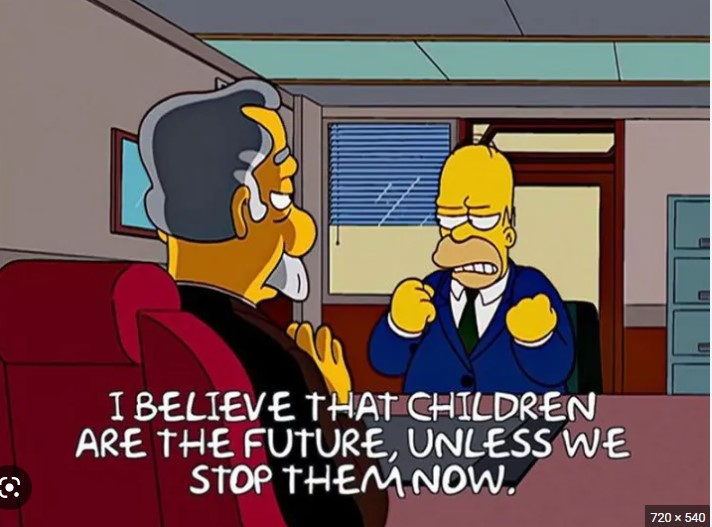

In [ ]:
# Show image of homer quote and convert to string
from IPython.display import display, Image
display(Image(filename='/content/Screenshot 2023-01-05 210515.jpg'))
homers_quote = "I believe that children are the future unless we stop them now"

In [ ]:
# Create a function that will make predictions
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Prediction: {pred_label}", "(The model predicts homer said this)" if pred_label > 0 else "(The model predicts Flanders said this)", f"Prob: {pred_prob[0][0]}")
  print(f"Quote:\n{sentence}")

In [ ]:
# Make a prediction on homer quote
predict_on_sentence(model= model_2, 
                    sentence=homers_quote)

1/1 [==============================] - 0s 31ms/step
Prediction: 1.0 (The model predicts homer said this) Prob: 0.5262690186500549
Quote:
I believe that children are the future unless we stop them now


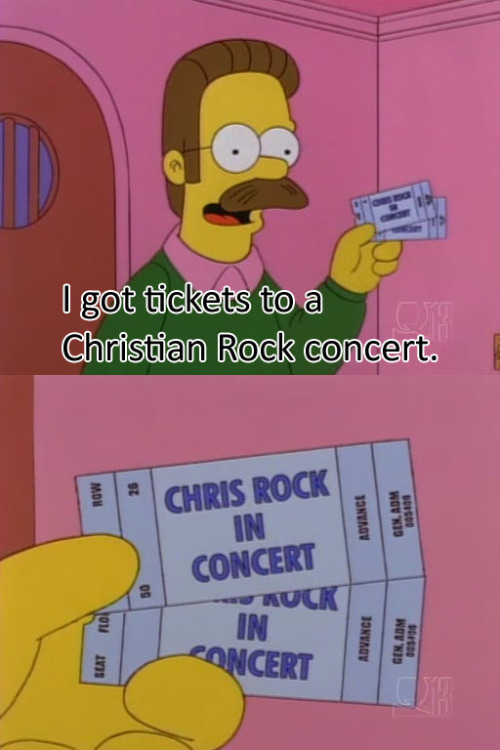

In [ ]:
# Now lets try for Flanders
from IPython.display import display, Image
display(Image(filename='/content/tumblr_ljkq7eN8J31qhqqmto1_500.jpg'))
Flanders_quote = "I got tickets to a Christian rock concert"


In [ ]:
predict_on_sentence(model=model_2,
                    sentence=Flanders_quote)

1/1 [==============================] - 0s 157ms/step
Prediction: 0.0 (The model predicts Flanders said this) Prob: 0.49556127190589905
Quote:
I got tickets to a Christian rock concert


In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model.save("model_SavedModel_format")